In [1]:
import numpy as np
import XNLdyn
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

In [2]:
use_multiprocessing = True

## Set up the problem
PAR = XNLdyn.XNLpars()


N_local_fluences_to_calculate = 30
N_pulse_energies = 20
Nsteps_r = 100

pulse_energy_max = 10e-6 # J
pulse_profile_sigma= 2 # µm rms

fluences_photons_nm2, _ = XNLdyn.calculate_fluences(Nsteps_r, pulse_energy_max, pulse_profile_sigma) # These are just to get an idea where to calculate Fluences
fluences_simulated = np.logspace(np.log10(np.min(fluences_photons_nm2)),
                                 np.log10(np.max(fluences_photons_nm2)),
                                 N_local_fluences_to_calculate)


sim_options = dict(t_span=[-40, 60],method='RK45', rtol=1e-6, atol=1e-8, plot = False)

In [3]:
if use_multiprocessing:
    try:
        mp.set_start_method('fork')  # 'spawn' on windows, may try "fork" or "forkserver" on unix machines
    except RuntimeError:
        pass
    with Pool(processes=10) as pool:
        tasklist = []
        """for fluence in fluences_simulated:
            tasklist.append(
                pool.apply_async(run_modified_simulation,
                                 (*(PAR, sim_options, ['I0', ], [fluence, ]),)
                                 )
            )
        """
        tasklist = [pool.apply_async(XNLdyn.run_modified_simulation,(*(PAR, sim_options,  ['I0',] , [fluence,]),)
                                             ) for fluence in fluences_simulated]
        resultlist = [res.get(timeout=60) for res in tasklist]
else:
    resultlist = []
    for fluence in fluences_simulated:
        result = XNLdyn.run_modified_simulation(PAR, sim_options, changed_parameters = ['I0',], new_values = [fluence,])
        resultlist.append(result)

Initializing a simulation where ['I0'] are changed to [0.2855681082811804]
Initializing a simulation where ['I0'] are changed to [0.5114648078888617]
Initializing a simulation where ['I0'] are changed to [0.3821754016694685]
Initializing a simulation where ['I0'] are changed to [0.9160555472504422]
Initializing a simulation where ['I0'] are changed to [0.6844926402014659]

Initializing a simulation where ['I0'] are changed to [1.640695024770211]


Initializing a simulation where ['I0'] are changed to [2.195739867041648]

Initializing a simulation where ['I0'] are changed to [1.2259558633111363]

Initializing a simulation where ['I0'] are changed to [2.938555606573697]
Initializing a simulation where ['I0'] are changed to [3.932664876445457]





Incident:  [0.28557151]
Transmitted:  [0.02765997]
Transmission:  [9.68582919]  %
Initializing a simulation where ['I0'] are changed to [5.263079928053727]

Incident:  [0.51147208]
Transmitted:  [0.04944772]
Transmission:  [9.66772575] Incident

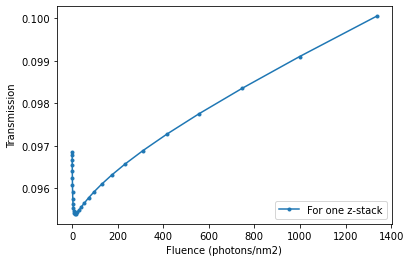

In [4]:
inc = np.array([r[0] for r in resultlist])
tr = np.array([r[1] for r in resultlist])
T = tr/inc

plt.figure()
plt.plot(fluences_simulated, T, '.-', label ='For one z-stack')
plt.xlabel('Fluence (photons/nm2)')
plt.ylabel('Transmission')
plt.legend(loc = 'lower right')

final_transmissions = np.zeros(N_pulse_energies)
final_incidence_check = np.zeros(N_pulse_energies)
final_consintency_check = np.zeros(N_pulse_energies)

done


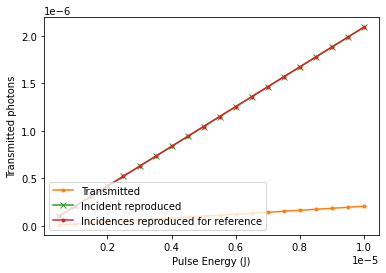

In [6]:
final_pulse_energies = np.linspace(1/N_pulse_energies, 1, N_pulse_energies)* pulse_energy_max
for ipe, pulse_en in enumerate(final_pulse_energies):
    local_fluences, dA = XNLdyn.calculate_fluences(Nsteps_r, pulse_en,
                                              pulse_profile_sigma)

    local_transmitted = np.interp(local_fluences, fluences_simulated, tr[:, 0])
    local_incidence_check = np.interp(local_fluences, fluences_simulated, inc[:, 0])
    local_consistency_check = np.interp(local_fluences, fluences_simulated, fluences_simulated)

    final_transmissions[ipe] = np.sum(local_transmitted*dA)
    final_incidence_check[ipe] = np.sum(local_incidence_check*dA) # should result equal final_pulse_energies
    final_consintency_check[ipe] = np.sum(local_consistency_check*dA) # should result equal final_pulse_energies

plt.figure()
plt.plot(final_pulse_energies, final_transmissions*850*1e6*PAR.echarge, 'C1.-', label = 'Transmitted')
plt.plot(final_pulse_energies, final_consintency_check*850*1e6*PAR.echarge, 'C2x-', label = 'Incident reproduced')
plt.plot(final_pulse_energies, final_incidence_check*850*1e6*PAR.echarge, 'C3.-', label = 'Incidences reproduced for reference')
plt.xlabel('Pulse Energy (J)')
plt.ylabel('Transmitted photons')
plt.legend(loc = 'lower left')
